In [1]:
pip install tensorflow


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
import os
from IPython.display import Image, display
import pandas as pd
import numpy as np
import seaborn as sns
import gc
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

(4026, 224, 224, 3)
(4026,)


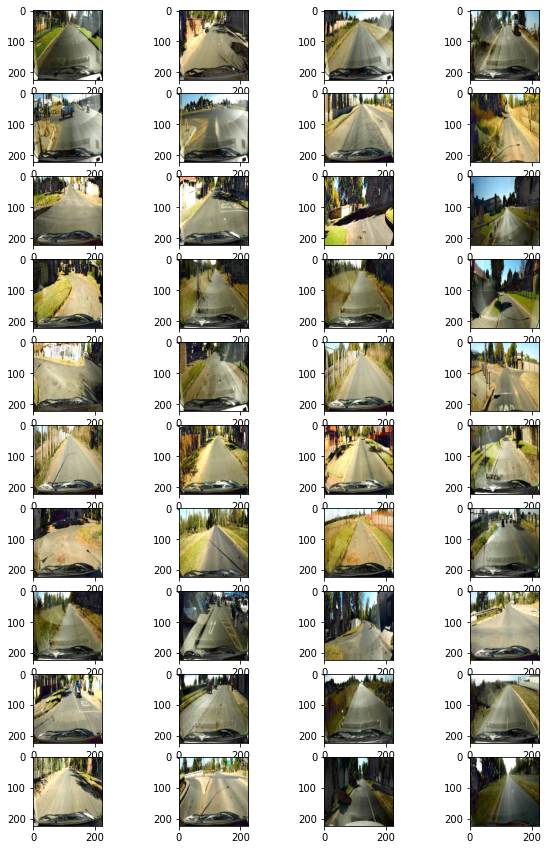

In [123]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

train_data = pd.read_csv("train_ids_labels.csv")
test_data = pd.read_csv("test_ids_only.csv")

def read_data(data, size, alpha=1.5, beta=-100, split="Training"):
    x, y = [], []
    for i in data.values:
        try:
            img = cv2.imread("/Users/vishnuselvaraj/Downloads/all_data-1/" + i[0] + ".JPG")
            if img is None:
                print("Error: Unable to read image at path:", "/path/to/your/images/" + i[0] + ".JPG")
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            adjusted_img = cv2.convertScaleAbs(img_rgb, alpha=float(alpha), beta=beta)
            cropped_img = adjusted_img[225:400, :]
            resizedimg = cv2.resize(cropped_img, (size, size))
            x.append(resizedimg)

            if split == "Training":
                y.append(i[1])
            elif split == "Testing":
                y.append(i[0])
        except Exception as e:
            print("Error processing image:", e)

    return np.array(x), np.array(y)

x_train, y_train = read_data(train_data, 224)

print(x_train.shape)
print(y_train.shape)

counter = 0
fig, axs = plt.subplots(10,4, figsize=(10, 15))
for i in range(0,4):
    for j in range(0,10):
        axs[j,i].imshow(x_train[counter])
        counter+=1 
plt.show()

In [124]:
train_data.Label.value_counts()

0    2365
1    1661
Name: Label, dtype: int64

<AxesSubplot:xlabel='Label', ylabel='count'>

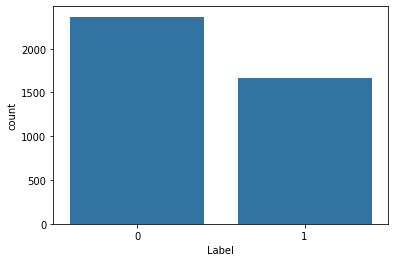

In [125]:
sns.countplot(data=train_data, x="Label")

In [126]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                            width_shift_range=.2,
                                                            height_shift_range=.2,
                                                            shear_range=.1,
                                                            horizontal_flip=True,
                                                            fill_mode='nearest',
                                                            zoom_range=.2)

trainGen = datagen.flow(x_train, y_train,
                        batch_size = 64,
                        seed = seed,
                        shuffle = True)

gc.collect()

86249

In [127]:
xception = tf.keras.applications.Xception(input_shape=(224, 224,3), include_top=False, weights="imagenet" )
globalaverage = tf.keras.layers.GlobalAveragePooling2D()(xception.layers[-1].output)

de_1 = tf.keras.layers.Dense(128, "relu")(globalaverage)
bn_1 = tf.keras.layers.BatchNormalization()(de_1)
de_2 = tf.keras.layers.Dense(64, "relu")(bn_1)
bn_2 = tf.keras.layers.BatchNormalization()(de_2)

de_3 = tf.keras.layers.Dense(128, "relu")(bn_2)
bn_3 = tf.keras.layers.BatchNormalization()(de_3)
de_4 = tf.keras.layers.Dense(64, "relu")(bn_3)
bn_4 = tf.keras.layers.BatchNormalization()(de_4)

de_5 = tf.keras.layers.Dense(32, "relu")(bn_4)
clf = tf.keras.layers.Dense(1, "sigmoid")(de_5)

model = tf.keras.models.Model(inputs=xception.layers[0].input, outputs=clf)

In [141]:
model.compile(optimizer="rmsprop", loss=tf.keras.losses.BinaryFocalCrossentropy(),metrics=['acc'])
gc.collect()
history=model.fit(trainGen, epochs = 10, batch_size=32)
gc.collect()

Epoch 1/10
63/63 [==============================] - 1531s 24s/step - loss: 0.1080 - acc: 0.8214
Epoch 2/10
63/63 [==============================] - 1137s 18s/step - loss: 0.0772 - acc: 0.8865
Epoch 3/10
63/63 [==============================] - 1379s 22s/step - loss: 0.0664 - acc: 0.9069
Epoch 4/10
63/63 [==============================] - 1288s 20s/step - loss: 0.0578 - acc: 0.9195
Epoch 5/10
63/63 [==============================] - 1341s 21s/step - loss: 0.0473 - acc: 0.9389
Epoch 6/10
63/63 [==============================] - 1330s 21s/step - loss: 0.0444 - acc: 0.9389
Epoch 7/10
63/63 [==============================] - 1073s 17s/step - loss: 0.0386 - acc: 0.9506
Epoch 8/10
63/63 [==============================] - 1207s 19s/step - loss: 0.0353 - acc: 0.9481
Epoch 9/10
63/63 [==============================] - 1205s 19s/step - loss: 0.0297 - acc: 0.9603
Epoch 10/10
63/63 [==============================] - 1203s 19s/step - loss: 0.0303 - acc: 0.9608


0

In [142]:
model.evaluate(x_train, y_train)

126/126 [==============================] - 132s 1s/step - loss: 0.0333 - acc: 0.9754


[0.03330574184656143, 0.9754098653793335]

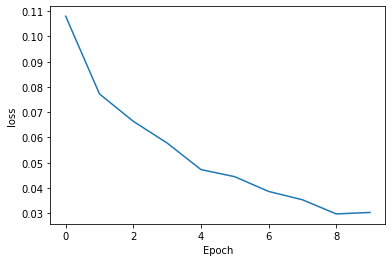

In [143]:
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

  no pothole       0.97      0.99      0.98      2365
     pothole       0.98      0.96      0.97      1661

    accuracy                           0.98      4026
   macro avg       0.98      0.97      0.97      4026
weighted avg       0.98      0.98      0.98      4026



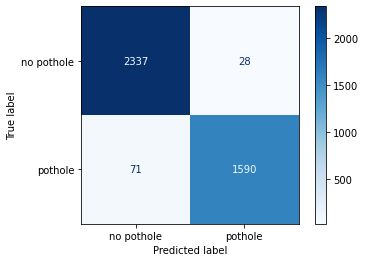

In [144]:
y_output = (model.predict(x_train, verbose = 0)).round()
print('Confusion Matrix')
cm = confusion_matrix(y_train, y_output)
print('Classification Report')
target_names = ['no pothole','pothole']
print(classification_report(y_train, y_output, target_names=target_names))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [145]:
x_test, images_id = read_data(test_data, 224, split="Testing")

In [146]:
predictions = [model.predict(i.reshape(1,224,224,3), verbose=0)[0][0] for i in x_test]


In [147]:
dic = {
    "Image_ID": images_id,
    "Label": predictions
}

submission = pd.DataFrame(dic)

In [148]:
submission.to_csv('./submission.csv', index=False)
gc.collect()

119003

In [149]:
def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):
    '''
    Function to visualize grad-cam heatmaps
    '''
    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )
    # Gradient Computations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normalize the heatmap
    return heatmap.numpy()

def superimpose_gradcam(img, heatmap, output_path="grad_cam_image.jpg", alpha=0.5):
    '''
    Superimpose Grad-CAM Heatmap on image
    '''

    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = c_map.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    
    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = image.array_to_img(superimposed_img)
    return superimposed_img
    #display(Image(output_path)) # Displaying Grad-CAM Superimposed Image
    
def GRAD_CAM(img, model, last_conv_layer = "block14_sepconv2_act"):
    fig, ax = plt.subplots(1,2)
    ax[0].matshow(get_heatmap(img.reshape(1,224,224,3), model, last_conv_layer))
    ax[1].imshow(superimpose_gradcam(img, get_heatmap(img.reshape(1,224,224,3), model, last_conv_layer)))
    plt.show()

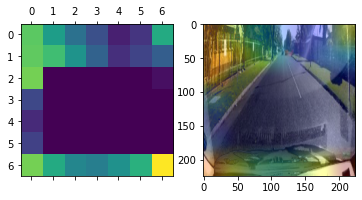

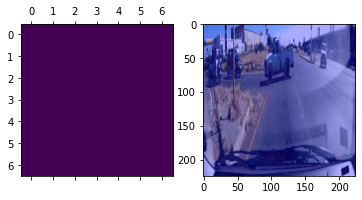

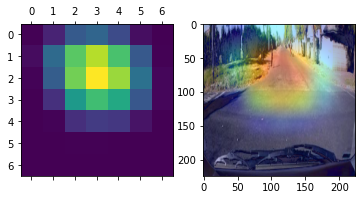

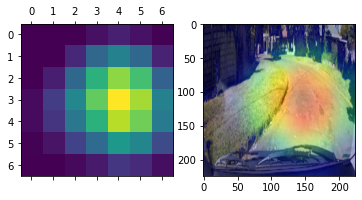

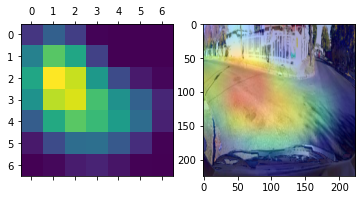

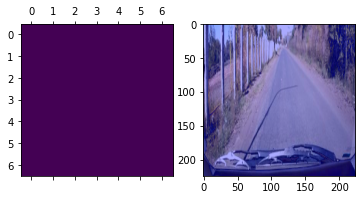

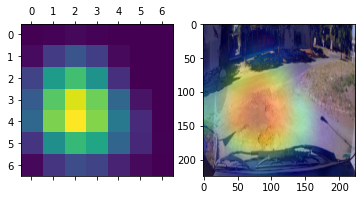

In [150]:
for i in range (7):
    GRAD_CAM(x_train[i], model)